<a href="https://colab.research.google.com/github/MilanCugur/DoubledMNIST/blob/master/DoubledMNIST_Classification_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier  # Estimate the quality of custers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import  SVC

# Load data

In [0]:
def extract_dataset(path):
  """
  extract DoubledMNIST dataset
  Argument: path to .zip file with the dataset
  Return value: x_train, y_train, x_test, y_test lists of numpy arrays 
  
  (DoubledMNIST dataset: train size 120k images 56x56, test size 20k images 56x56)
  """
  # import libraries
  import os                     # for basic os operations
  from zipfile import ZipFile 
  from skimage import io
  import numpy as np
  import shutil
  
  if not path.endswith('.zip'):
    raise ValueError("Error: path is not '.zip' file")
  
  archive = ZipFile(path, 'r')  # extract
  archive.extractall('./DoubledMNIST')
  archive.close()
  del archive
  
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  
  for file in os.listdir('./DoubledMNIST/train'):
    img = io.imread(os.path.join('./DoubledMNIST/train', file))
    x_train.append(np.array(img))
    y_train.append(int(file.split('_')[1]))
  
  for file in os.listdir('./DoubledMNIST/test'):
    img = io.imread(os.path.join('./DoubledMNIST/test', file))
    x_test.append(np.array(img))
    y_test.append(int(file.split('_')[1]))
    
  shutil.rmtree('./DoubledMNIST')
  return x_train, y_train, x_test, y_test

In [0]:
%%time
x_train, y_train, x_test, y_test = extract_dataset('./drive/My Drive/dm_sem/DoubledMNIST.zip')

CPU times: user 1min 2s, sys: 15.4 s, total: 1min 17s
Wall time: 1min 21s


In [0]:
print(len(x_train))  # size check
print(len(y_train))
print(len(x_test))
print(len(y_test))

120000
120000
20000
20000


In [0]:
x_train[0]

array([[255, 255, 255, ..., 254, 254, 255],
       [255, 255, 255, ..., 254, 254, 255],
       [255, 255, 255, ..., 254, 254, 255],
       ...,
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [255, 255, 255, ..., 254, 254, 255]], dtype=uint8)

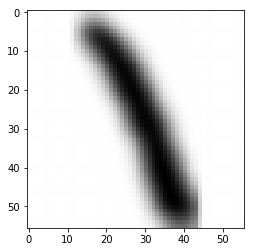

1


In [0]:
plt.imshow(x_train[0], cmap='gray')
plt.show()

print(y_train[0])

In [0]:
x_train[0].shape  # check image shape

(56, 56)

In [0]:
type(x_train[0])  # check image type

numpy.ndarray

# Data

In [0]:
# Data for evaluation
x_train_knn = np.array([img.flatten()/255.0 for img in x_train])  # image preprocessiong, convert it to [0, 1] and flatten for knn; knn dont requests normalize data?
x_test_knn = np.array([img.flatten()/255.0 for img in x_test])

In [0]:
# Data for parameter choosing (knn, svm, dt)
x_train_choose = np.array([img.flatten()/255.0 for img in x_train[:2400]])  
y_train_choose = y_train[:2400]
x_test_choose = np.array([img.flatten()/255.0 for img in x_test[:200]])
y_test_choose = y_test[:200]

# KNearest Neighbours

## Choose parameters

In [32]:
%%time

ks = [1,3,5,7,9,10,15,20]  # choose appropriate k
ps = [1, 2]
ws = ['uniform', 'distance']

max_params = {'k':0, 'p':0, 'w':0}
max_score = 0
for k in ks:
  for p in ps:
    for w in ws:
      knn = KNeighborsClassifier(n_neighbors=k, p=p, weights=w)  # approx ~ 1nn
      knn.fit(x_train_choose, y_train_choose)
  
      score = accuracy_score(y_test_choose, knn.predict(x_test_choose))  # check acc score
      print(f"knn(k={k}, p={p}, weights={w}) : {score}")
      if score>max_score:
        max_params['k'] = k
        max_params['p'] = p
        max_params['w'] = w
        max_score = score
      del knn

knn(k=1, p=1, weights=uniform) : 0.91
knn(k=1, p=1, weights=distance) : 0.91
knn(k=1, p=2, weights=uniform) : 0.92
knn(k=1, p=2, weights=distance) : 0.92
knn(k=3, p=1, weights=uniform) : 0.915
knn(k=3, p=1, weights=distance) : 0.905
knn(k=3, p=2, weights=uniform) : 0.925
knn(k=3, p=2, weights=distance) : 0.915
knn(k=5, p=1, weights=uniform) : 0.905
knn(k=5, p=1, weights=distance) : 0.895
knn(k=5, p=2, weights=uniform) : 0.925
knn(k=5, p=2, weights=distance) : 0.935
knn(k=7, p=1, weights=uniform) : 0.915
knn(k=7, p=1, weights=distance) : 0.915
knn(k=7, p=2, weights=uniform) : 0.945
knn(k=7, p=2, weights=distance) : 0.94
knn(k=9, p=1, weights=uniform) : 0.91
knn(k=9, p=1, weights=distance) : 0.92
knn(k=9, p=2, weights=uniform) : 0.925
knn(k=9, p=2, weights=distance) : 0.925
knn(k=10, p=1, weights=uniform) : 0.93
knn(k=10, p=1, weights=distance) : 0.92
knn(k=10, p=2, weights=uniform) : 0.93
knn(k=10, p=2, weights=distance) : 0.93
knn(k=15, p=1, weights=uniform) : 0.895
knn(k=15, p=1, weig

In [33]:
print(max_params)
print(max_score)

{'k': 7, 'p': 2, 'w': 'uniform'}
0.945


## Evaluate on best params

In [0]:
k = best_params['k']
p = best_params['p']
w = best_params['w']

In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=k, p=p, weights=w)  # approx ~ 1nn
knn.fit(x_train_knn, y_train)  

CPU times: user 1min 2s, sys: 254 ms, total: 1min 2s
Wall time: 1min 2s


In [0]:
%%time

score = accuracy_score(y_test, knn.predict(x_test_knn))  # check acc score
print(score)

0.989
CPU times: user 9min 52s, sys: 160 ms, total: 9min 52s
Wall time: 9min 52s


In [13]:
Nall = len(y_test)  # calculate precision, manually
Ntrue = 0
for i in tqdm(range(len(y_test))):
  if knn.predict([x_test_knn[i]])[0]==y_test[i]:
    Ntrue += 1
print(Ntrue/Nall*100.0)  # 98.19%

100%|██████████| 20000/20000 [3:16:54<00:00,  1.56it/s]


# Support Vector Machine (SVC)

In [0]:
parameters = [{'C': [pow(2,x) for x in range(-6,10,2)],
               'kernel' : ['linear']
               },

              {'C': [pow(2,x) for x in range(-6,10,2)],
               'kernel': ['poly'],
               'degree': [2, 3, 4, 5],
               'gamma': np.arange(0.1, 1.1, 0.1),
               'coef0': np.arange(0, 2, 0.5)
               },

                {'C': [pow(2,x) for x in range(-6,10,2)],
               'kernel' : ['rbf'],
               'gamma': np.arange(0.1, 1.1, 0.1),
               },

               {'C': [pow(2,x) for x in range(-6,10,2)],
               'kernel' : ['sigmoid'],
               'gamma': np.arange(0.1, 1.1, 0.1),
               'coef0': np.arange(0, 2, 0.5)
               }]

In [39]:
%%time
clf = GridSearchCV(SVC(), parameters, scoring='f1_macro')
clf.fit(x_test_choose, y_test_choose)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cla

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.015625, 0.0625, 0.25, 1, 4, 16...
                         {'C': [0.015625, 0.0625, 0.25, 1, 4, 16, 64, 256],
                          'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'kernel': ['rbf']},
                         {'C': [0.015625, 0.0625, 0.25, 1, 4, 16, 64, 256],
                          'coef0': array([0. , 0.5, 1. , 1.5]),
                          'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         

In [40]:
%%time
print("Ocena uspeha po klasifikatorima:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) za %s" % (mean, std * 2, params))
print()

print("Najbolji parametri:")
print(clf.best_params_)

print(clf.best_estimator_.classes_)
print('Broj podrzavajucih vektora', clf.best_estimator_.n_support_)


Ocena uspeha po klasifikatorima:
0.846 (+/-0.060) za {'C': 0.015625, 'kernel': 'linear'}
0.856 (+/-0.045) za {'C': 0.0625, 'kernel': 'linear'}
0.856 (+/-0.045) za {'C': 0.25, 'kernel': 'linear'}
0.856 (+/-0.045) za {'C': 1, 'kernel': 'linear'}
0.856 (+/-0.045) za {'C': 4, 'kernel': 'linear'}
0.856 (+/-0.045) za {'C': 16, 'kernel': 'linear'}
0.856 (+/-0.045) za {'C': 64, 'kernel': 'linear'}
0.856 (+/-0.045) za {'C': 256, 'kernel': 'linear'}
0.855 (+/-0.072) za {'C': 0.015625, 'coef0': 0.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.855 (+/-0.072) za {'C': 0.015625, 'coef0': 0.0, 'degree': 2, 'gamma': 0.2, 'kernel': 'poly'}
0.855 (+/-0.072) za {'C': 0.015625, 'coef0': 0.0, 'degree': 2, 'gamma': 0.30000000000000004, 'kernel': 'poly'}
0.855 (+/-0.072) za {'C': 0.015625, 'coef0': 0.0, 'degree': 2, 'gamma': 0.4, 'kernel': 'poly'}
0.855 (+/-0.072) za {'C': 0.015625, 'coef0': 0.0, 'degree': 2, 'gamma': 0.5, 'kernel': 'poly'}
0.855 (+/-0.072) za {'C': 0.015625, 'coef0': 0.0, 'degree': 2, '

In [0]:
print("Izvestaj za trening skup:")
y_true, y_pred = y_train, clf.predict(x_train)
print(classification_report(y_true, y_pred))
print()

In [0]:
print("Izvestaj za test skup:")
y_true, y_pred = y_test, clf.predict(x_test)
print(classification_report(y_true, y_pred))
print()

# Decision Tree

# Deep Neural Network

# Visualisation

In [0]:
# TODO: SPSS Modeller